# ATAC-seq Module3: Downstream Analysis

<img src="https://storage.googleapis.com/unmc_atac_data_examples/Tutorial3/images/ATACseqWorkflowLesson3.jpg" alt="Drawing" style="width: 1000px;"/>

## Overview & Purpose
In the previous sections of this module we performed preprocessing quality control, mapping, deduplication, visualization, profiling aroud TSSs, and peak identification. In this section we will focus on differential peak identification, motif footprinting, and annotation of nearby genomic features. 

### Required Files
In this stage of the module you will use several of the files that we prepared in the previous sections. Don't worry if you are just jumping in now, we have examples of these files saved and will include a step that copies them for your use. You can also use this module on your own data or any published ATAC-seq dataset, but you should complete the mappping and deduplication steps first.

<div class="alert-info" style="font-size:200%">
STEP1: Setup Environment
</div>

Initial items to configure your google cloud environment. In this step we will use conda to install the following packages:

Differential Peak Idnetification:
[manorm](https://anaconda.org/bioconda/manormfast)

Genome Annotation:
[homer](https://anaconda.org/bioconda/homer)

Motif Analysis:
[tobias](https://anaconda.org/bioconda/tobias)


In [1]:
#!python -m ipykernel install --user --name ATACtraining
numthreads=!lscpu | grep '^CPU(s)'| awk '{print $2-1}'
numthreadsint = int(numthreads[0])
!conda config --prepend channels bioconda
!conda install -y -c bioconda manorm tobias homer
!pip install jupyterquiz
from jupyterquiz import display_quiz
from IPython.display import IFrame
from IPython.display import display
import pandas as pd


Retrieving notices: ...working... done
Solving environment: unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: / ^C
unsuccessful initial attempt using frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



In [6]:
# !conda install -y -c bioconda manorm #installed
# !conda install -y -c bioconda tobias ### this is problematic --- build from source
# !conda install -y -c bioconda homer #installed

In [2]:
# !conda install -y -c bioconda manorm tobias homer

/ 

## Setup FileSystem
Now lets create some folders to stay organized and copy over our prepared fastq files. We're going to create a directory called "Tutorial1" which we'll use for this module. We'll then create subfolders for our InputFiles and for the files that we'll be creating during this module. We'll also copy over the fasta file for chromosome 4 as well as some bowtie2 index files (don't worry we'll teach you how to create these index files).

In [7]:
#These commands create our directory structure.
#!cd $HOMEDIR
#!mkdir -p Tutorial3
#!mkdir -p Tutorial3/InputFiles
!mkdir -p Tutorial3/GenomeAnnotation
!mkdir -p Tutorial3/DiffPeaks
!mkdir -p Tutorial3/MotifFootprinting
#!mkdir -p Tutorial3/LessonImages
!mkdir -p Tutorial3/Plots
#!cd ./Tutorial3
#!echo $PWD

# #These commands help identify the google cloud storage bucket where the example files are held.
# project_id = "nosi-unmc-seq"
# original_bucket = "gs://unmc_atac_data_examples/Tutorial3"
# #!gsutil -m cp $original_bucket/images/* Tutorial3/LessonImages
# #!gsutil -m cp $original_bucket/Annotations/* Tutorial3/GenomeAnnotations
# #This command copies our example files to the Tutorial1/Inputfiles folder that we created above.
# ! gsutil -m cp $original_bucket/InputFiles/* Tutorial3/InputFiles



### OK
Let's make sure that the files copied correctly. You should see 2 .bam files, 2 .bai files, and 2 .narrowPeak files after running the following command:

In [8]:
!ls Tutorial3/InputFiles/*

Tutorial3/InputFiles/CTL_dedup.bam
Tutorial3/InputFiles/CTL_dedup.bam.bai
Tutorial3/InputFiles/CTL_peaks.narrowPeak
Tutorial3/InputFiles/Mutant_dedup.bam
Tutorial3/InputFiles/Mutant_dedup.bam.bai
Tutorial3/InputFiles/Mutant_peaks.narrowPeak
Tutorial3/InputFiles/chr4.fa
Tutorial3/InputFiles/chr4.fa.fai


<div class="alert-info" style="font-size:200%">
Differential Peak Identification
</div>
If you have two or more samples and desire to discover differential peaks, we recommend using manorm. Novices may be tempted to simply intersect the two peak lists to find the overlap, however this is highly inadvisable. 

<div class="alert-info" style="font-size:200%">
Interactive Quiz Question 1: Click on the correct answer in following cell.
</div>

In [9]:
display_quiz("Tutorial3/LessonImages/DiffPeaks.json")

<IPython.core.display.Javascript object>

### Consider the below peak which was identified in both the control and mutant sample. A simple intersect would result in this peak being reported as unchanged between the two samples. To represent the differences we will use [manorm](https://anaconda.org/bioconda/manormfast).

<img src="Tutorial3/LessonImages/PeakOverlapProblem.jpg" alt="Drawing" style="width: 100px;"/>



In [10]:
#We specify several non-default parameters to better reflect ATAC-seq data
!manorm --p1 Tutorial3/InputFiles/CTL_peaks.narrowPeak --p2 Tutorial3/InputFiles/Mutant_peaks.narrowPeak --r1 Tutorial3/InputFiles/CTL_dedup.bam --r2 Tutorial3/InputFiles/Mutant_dedup.bam --rf bam --n1 CTL --n2 Mutant --pe -w 1000 -o Tutorial3/DiffPeaks --wa 2> Tutorial3/DiffPeaks/log_manorm.txt
print("done")

done


The above command will write out several files including the differential peaks for each sample as well as the unchanged peaks.

In [11]:
!ls Tutorial3/DiffPeaks/output_filters

CTL_vs_Mutant_M_above_1.0_biased_peaks.bed   CTL_vs_Mutant_unbiased_peaks.bed
CTL_vs_Mutant_M_below_-1.0_biased_peaks.bed


In [12]:
#Let's also check the format of these files
!head Tutorial3/DiffPeaks/output_filters/CTL_vs_Mutant_M_above_1.0_biased_peaks.bed

chr4	52059325	52059732	CTL_unique	2.20155
chr4	52298589	52298799	CTL_unique	1.09775
chr4	52550105	52550494	CTL_unique	1.29536
chr4	52698223	52698464	CTL_unique	1.84416
chr4	52834103	52834470	CTL_unique	1.26119
chr4	52884232	52884622	CTL_unique	1.09835
chr4	52968329	52968671	CTL_unique	1.41519
chr4	52993914	52994157	CTL_unique	1.22576
chr4	53595301	53595477	CTL_unique	1.20393
chr4	53702525	53703113	CTL_unique	1.07373


In [13]:
#We can also count how many are in each.
!wc -l Tutorial3/DiffPeaks/output_filters/*bed

  124 Tutorial3/DiffPeaks/output_filters/CTL_vs_Mutant_M_above_1.0_biased_peaks.bed
   74 Tutorial3/DiffPeaks/output_filters/CTL_vs_Mutant_M_below_-1.0_biased_peaks.bed
  590 Tutorial3/DiffPeaks/output_filters/CTL_vs_Mutant_unbiased_peaks.bed
  788 total


In [14]:
#Our log file tells us this information as well
!tail Tutorial3/DiffPeaks/log_manorm.txt

==== Stats ====
Total read pairs of sample 1: 167,920
Total read pairs of sample 2: 219,380
Total peaks of sample 1: 650 (unique: 277 common: 373)
Total peaks of sample 2: 560 (unique: 190 common: 370)
Number of merged common peaks: 369
M-A model: M = -0.04460 * A +0.18904
590 peaks are filtered as unbiased peaks
124 peaks are filtered as sample1-biased peaks
74 peaks are filtered as sample2-biased peaks


<div class="alert-info" style="font-size:100%">
Annotating Peaks
</div>

Let's take the differential peaks and annotate them with nearby genes and perform gene ontology using [homer](https://anaconda.org/bioconda/homer).

First we need to reformat the differential peaks file to the format required by homer.

In an earlier command, we examined the format of manorm's ouput using head and saw that it outputs a five column format. We will change this to a 6 column bed format including a unique name for each peak.

In [15]:
#This command will reformat the peaks file including the line number in naming the peaks (NR) as well as a place-holder strand in the 6th column (note that peaks don't necessarily have a strand, but the format requires this column). The -F \t tells awk that the file is tab delimited.
!awk '{print $1"\t"$2"\t"$3"\t"$4"_"NR"\t"$5"\t+"}' Tutorial3/DiffPeaks/output_filters/CTL_vs_Mutant_M_above_1.0_biased_peaks.bed > Tutorial3/GenomeAnnotation/CTL_specific_peaks.bed
#Let's head this to compare
!head Tutorial3/GenomeAnnotation/CTL_specific_peaks.bed

chr4	52059325	52059732	CTL_unique_1	2.20155	+
chr4	52298589	52298799	CTL_unique_2	1.09775	+
chr4	52550105	52550494	CTL_unique_3	1.29536	+
chr4	52698223	52698464	CTL_unique_4	1.84416	+
chr4	52834103	52834470	CTL_unique_5	1.26119	+
chr4	52884232	52884622	CTL_unique_6	1.09835	+
chr4	52968329	52968671	CTL_unique_7	1.41519	+
chr4	52993914	52994157	CTL_unique_8	1.22576	+
chr4	53595301	53595477	CTL_unique_9	1.20393	+
chr4	53702525	53703113	CTL_unique_10	1.07373	+


Now let's configure homer to recognize our genome build. We aligned our reads to hg38, so we'll have homer use that.

In [16]:
!perl /opt/conda/share/homer/configureHomer.pl -install hg38 2> Tutorial3/DiffPeaks/homer_log1.txt
print("done")

done


Let's use that reformatted peak file to get nearby genes and perform gene onotology analysis.

In [19]:
!annotatePeaks.pl Tutorial3/GenomeAnnotation/CTL_specific_peaks.bed hg38 -go Tutorial3/GenomeAnnotation/CTL_GO -annStats Tutorial3/GenomeAnnotation/CTL_annStats.txt > Tutorial3/GenomeAnnotation/CTL_specific_Annotated.txt


	Peak file = Tutorial3/GenomeAnnotation/CTL_specific_peaks.bed
	Genome = hg38
	Organism = human
	Will perform Gene Ontology analysis - output to directory = Tutorial3/GenomeAnnotation/CTL_GO
	Peak/BED file conversion summary:
		BED/Header formatted lines: 124
		peakfile formatted lines: 0
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 124
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:.
		Annotation	Number of peaks	Total size (bp)	Log2 Ratio (obs/exp)	LogP enrichment (+values depleted)
		3UTR	0.0	1226327	-0.852	0.802
		miRNA	0.0	3258	-0.003	0.002
		ncRNA	0.0	315963	-0.271	0.206
		TTS	1.0	1306500	0.231	-0.554
		pseudo	0.0	40049	-0.037	0.026
		Exon	0.0	1490268	-0.985	0.975
		Intron	33.0	73166083	-

Let's look at the output files. First, let's look at the first 2 lines of at our annotation stats.

In [20]:
#Clean up duplicate entries
!sort -u Tutorial3/GenomeAnnotation/CTL_annStats.txt | grep -v Annotation > Tutorial3/GenomeAnnotation/CTL_annStats_clean.txt

#Load results into a pandas table
annstats = pd.read_csv("Tutorial3/GenomeAnnotation/CTL_annStats_clean.txt", sep='\t', header=None, names=['annotation','peakcount','size','foldenrichment','log10significance'])

#View entries sorted by enrichment
annstats_sorted = annstats.sort_values(by=["foldenrichment"], ascending=False)
display(annstats_sorted)



,annotation,peakcount,size,foldenrichment,log10significance
1,5UTR,1.0,114432,3.745,-2.632
14,Promoter,5.0,1403974,2.450,-6.038
11,LTR,27.0,20757981,0.997,-7.957
6,Intergenic,39.0,48657251,0.298,-2.484
24,TTS,1.0,1306500,0.232,-0.554
23,TTS,1.0,1306500,0.231,-0.554
7,Intergenic,84.0,111121736,0.213,-3.865
20,SINE?,0.0,130,-0.000,0.000
33,tRNA,0.0,2852,-0.003,0.002
26,miRNA,0.0,3258,-0.003,0.002


From this we can see highest enrichment in 5' UTRs and promoters.

Let's plot the results as a barplot.


<Axes: xlabel='annotation'>

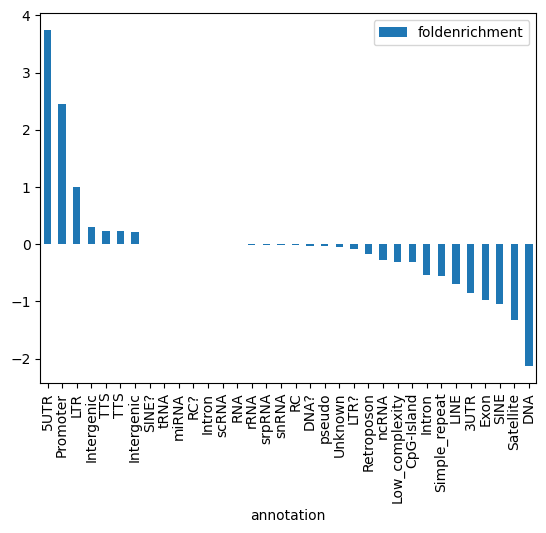

In [21]:
annstats_sorted.plot.bar(x="annotation", y="foldenrichment")

Homer also outputs the nearest annotation for each peak. Let's look at the first few lines of our annotation file.

In [22]:
!head -4 Tutorial3/GenomeAnnotation/CTL_specific_Annotated.txt

PeakID (cmd=annotatePeaks.pl Tutorial3/GenomeAnnotation/CTL_specific_peaks.bed hg38 -go Tutorial3/GenomeAnnotation/CTL_GO -annStats Tutorial3/GenomeAnnotation/CTL_annStats.txt)	Chr	Start	End	Strand	Peak Score	Focus Ratio/Region Size	Annotation	Detailed Annotation	Distance to TSS	Nearest PromoterID	Entrez ID	Nearest Unigene	Nearest Refseq	Nearest Ensembl	Gene Name	Gene Alias	Gene Description	Gene Type
CTL_unique_56	chr4	64144792	64145494	+	3.01611	NA	Intergenic	HERVK11-int|LTR|ERVK	264307	NM_001010874	253017	Hs.227752	NM_001010874	ENSG00000205678	TECRL	CPVT3|GPSN2L|SRD5A2L2|TERL	trans-2,3-enoyl-CoA reductase like	protein-coding
merged_common_90	chr4	54545647	54546360	+	2.38644	NA	Intergenic	Intergenic	61128	NR_134657	339978		NR_134657	ENSG00000250456	LINC02260	-	long intergenic non-protein coding RNA 2260	ncRNA
CTL_unique_51	chr4	62835674	62836120	+	2.34453	NA	Intergenic	Intergenic	-674132	NR_110595	101927186	Hs.723269	NR_110595		ADGRL3-AS1	LPHN3-AS1	adhesion G protein-coupled receptor 

Lastly, let's take a look at the gene ontology results

In [23]:
#list the files in our GO directory
!ls Tutorial3/GenomeAnnotation/CTL_GO/

biocyc.txt		interactions.txt	  prints.txt
biological_process.txt	interpro.txt		  prosite.txt
cellular_component.txt	kegg.txt		  reactome.txt
chromosome.txt		lipidmaps.txt		  smart.txt
cosmic.txt		molecular_function.txt	  smpdb.txt
gene3d.txt		msigdb.txt		  wikipathways.txt
geneOntology.html	pathwayInteractionDB.txt
gwas.txt		pfam.txt


Let's view the top terms in the biological_process category.

In [24]:

bp_GO = pd.read_csv("Tutorial3/GenomeAnnotation/CTL_GO/biological_process.txt", sep='\t')

#keep most significant
bp_GO_top10 = bp_GO.nsmallest(10, "logP")
display(bp_GO_top10)

,TermID,Term,Enrichment,logP,Genes in Term,Target Genes in Term,Fraction of Targets in Term,Total Target Genes,Total Genes,Entrez Gene IDs,Gene Symbols
0,GO:0052695,cellular glucuronidation,8.476896e-07,-13.980751,18,3,0.15,20,18680,"79799,7364,10941","UGT2A3,UGT2B7,UGT2A1"
1,GO:0019585,glucuronate metabolic process,1.833506e-06,-13.209280,23,3,0.15,20,18680,"10941,79799,7364","UGT2A1,UGT2A3,UGT2B7"
2,GO:0006063,uronic acid metabolic process,1.833506e-06,-13.209280,23,3,0.15,20,18680,"79799,7364,10941","UGT2A3,UGT2B7,UGT2A1"
3,GO:0010817,regulation of hormone levels,1.370570e-05,-11.197699,528,6,0.30,20,18680,"5978,7364,2044,6783,9575,27284","REST,UGT2B7,EPHA5,SULT1E1,CLOCK,SULT1B1"
4,GO:0006068,ethanol catabolic process,7.141780e-05,-9.546963,12,2,0.10,20,18680,"27284,6783","SULT1B1,SULT1E1"
5,GO:0034310,primary alcohol catabolic process,1.134005e-04,-9.084585,15,2,0.10,20,18680,"27284,6783","SULT1B1,SULT1E1"
6,GO:0051923,sulfation,1.295173e-04,-8.951696,16,2,0.10,20,18680,"6783,27284","SULT1E1,SULT1B1"
7,GO:0006067,ethanol metabolic process,2.259286e-04,-8.395291,21,2,0.10,20,18680,"27284,6783","SULT1B1,SULT1E1"
8,GO:0050427,3'-phosphoadenosine 5'-phosphosulfate metaboli...,2.963633e-04,-8.123925,24,2,0.10,20,18680,"27284,6783","SULT1B1,SULT1E1"
9,GO:0034035,purine ribonucleoside bisphosphate metabolic p...,3.219272e-04,-8.041185,25,2,0.10,20,18680,"27284,6783","SULT1B1,SULT1E1"


We can also plot the enrichment scores

Note that our results may look a little odd because we have severely downsampled the data to run quickly and focus on a single region of chr4. 

<Axes: xlabel='Term'>

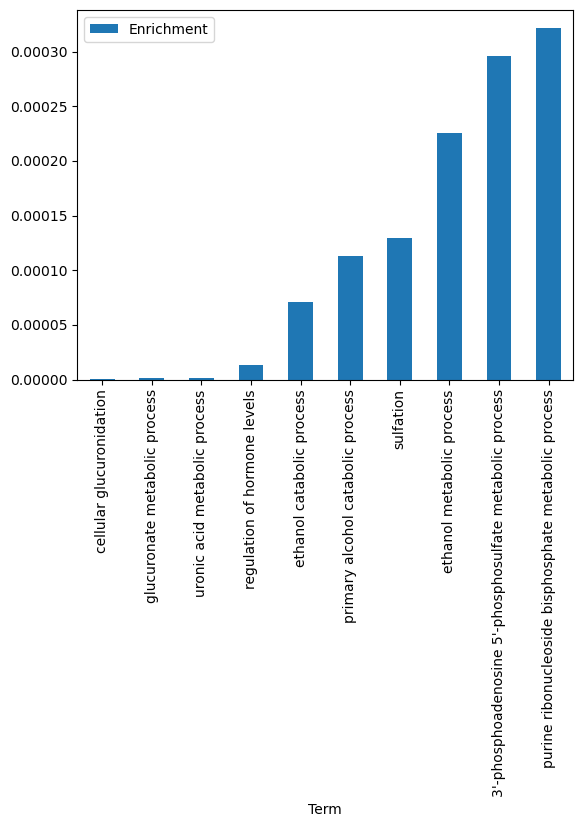

In [25]:
bp_GO_top10.plot.bar(x="Term", y="Enrichment")

Homer also saves an html file where you can navigate through the various categories.

In [26]:
#View the html results
IFrame(src='Tutorial3/GenomeAnnotation/CTL_GO/geneOntology.html', width=900, height=600)

In the above html you can click throught the different ontology categories to view enriched terms and scores for genes near our differential peaks. Note that there are links to motifs, but these lead to "pages not found" because we have yet to do this analysis. We will run motif analysis in the next section using TOBIAS.

<div class="alert-info" style="font-size:200%">
Motif Footprinting
</div>

### ATAC-seq can be used to identify accessibility at transcription factor (TF) binding sites. We'll use [tobias](https://anaconda.org/bioconda/tobias).

<img src="Tutorial3/LessonImages/TobiasFigure.jpg" alt="Drawing" style="width: 500px;"/>

From: [Bentsen et al., Nat. Comm. 2020](https://www.nature.com/articles/s41467-020-18035-1)

Tn5 insertion during ATAC-seq has a sequence bias. In our first step, let's correct for that bias.

In [27]:
#Index the bam  
!samtools index Tutorial3/InputFiles/CTL_dedup.bam
!samtools index Tutorial3/InputFiles/Mutant_dedup.bam
#Tn5 has an insertion sequence bias, which Tobias can correct for. Let's use the master list of peaks provided by manorm, but we need to first remove the header and extra columns.
!cat Tutorial3/DiffPeaks/CTL_vs_Mutant_all_MAvalues.xls | cut -f 1-3 | grep -v start > Tutorial3/MotifFootprinting/MasterPeakList.bed

#Now let's do the signal correction
!TOBIAS ATACorrect --bam Tutorial3/InputFiles/CTL_dedup.bam --genome Tutorial3/InputFiles/chr4.fa --peaks Tutorial3/MotifFootprinting/MasterPeakList.bed --outdir Tutorial3/MotifFootprinting --prefix CTL --cores $numthreadsint --verbosity 1
#Let's also do this for the mutant
!TOBIAS ATACorrect --bam Tutorial3/InputFiles/Mutant_dedup.bam --genome Tutorial3/InputFiles/chr4.fa --peaks Tutorial3/MotifFootprinting/MasterPeakList.bed --outdir Tutorial3/MotifFootprinting --prefix Mutant --cores $numthreadsint --verbosity 1

print("done")

# TOBIAS 0.16.0 ATACorrect (run started 2023-09-10 04:21:57.812793)
# Working directory: /home/jupyter
# Command line call: TOBIAS ATACorrect --bam Tutorial3/InputFiles/CTL_dedup.bam --genome Tutorial3/InputFiles/chr4.fa --peaks Tutorial3/MotifFootprinting/MasterPeakList.bed --outdir Tutorial3/MotifFootprinting --prefix CTL --cores 7 --verbosity 1

# ----- Input parameters -----
# bam:	Tutorial3/InputFiles/CTL_dedup.bam
# genome:	Tutorial3/InputFiles/chr4.fa
# peaks:	Tutorial3/MotifFootprinting/MasterPeakList.bed
# regions_in:	None
# regions_out:	None
# blacklist:	None
# extend:	100
# split_strands:	False
# norm_off:	False
# track_off:	[]
# drop_chroms:	['chrM', 'chrMT', 'M', 'MT', 'Mito']
# k_flank:	12
# read_shift:	[4, -5]
# bg_shift:	100
# window:	100
# score_mat:	DWM
# bias_pkl:	None
# prefix:	CTL
# outdir:	/home/jupyter/Tutorial3/MotifFootprinting
# cores:	7
# split:	100
# verbosity:	1


# ----- Output files -----
# /home/jupyter/Tutorial3/MotifFootprinting/CTL_uncorrected.bw
# /h

Now let's use the bias-corrected bigwig files to calculate footprint scores around peaks

In [28]:
!TOBIAS ScoreBigwig -s Tutorial3/MotifFootprinting/CTL_corrected.bw -r Tutorial3/MotifFootprinting/MasterPeakList.bed -o Tutorial3/MotifFootprinting/CTL_footprintscores.bw --cores $numthreadsint --verbosity 1

#Let's do the same for our mutant sample
!TOBIAS ScoreBigwig -s Tutorial3/MotifFootprinting/Mutant_corrected.bw -r Tutorial3/MotifFootprinting/MasterPeakList.bed -o Tutorial3/MotifFootprinting/Mutant_footprintscores.bw --cores $numthreadsint --verbosity 1


# TOBIAS 0.16.0 ScoreBigwig (run started 2023-09-10 04:24:36.386281)
# Working directory: /home/jupyter
# Command line call: TOBIAS ScoreBigwig -s Tutorial3/MotifFootprinting/CTL_corrected.bw -r Tutorial3/MotifFootprinting/MasterPeakList.bed -o Tutorial3/MotifFootprinting/CTL_footprintscores.bw --cores 7 --verbosity 1

# ----- Input parameters -----
# signal:	Tutorial3/MotifFootprinting/CTL_corrected.bw
# output:	Tutorial3/MotifFootprinting/CTL_footprintscores.bw
# regions:	Tutorial3/MotifFootprinting/MasterPeakList.bed
# score:	footprint
# absolute:	False
# extend:	100
# smooth:	1
# min_limit:	None
# max_limit:	None
# fp_min:	20
# fp_max:	50
# flank_min:	10
# flank_max:	30
# window:	100
# cores:	7
# split:	100
# verbosity:	1


# ----- Output files -----
# Tutorial3/MotifFootprinting/CTL_footprintscores.bw



# TOBIAS 0.16.0 ScoreBigwig (run started 2023-09-10 04:24:50.704446)
# Working directory: /home/jupyter
# Command line call: TOBIAS ScoreBigwig -s Tutorial3/MotifFootprinting/Muta

Now that we have our corrected signal and footprint scores, let's do TF binding site prediciton as well as differential footprinting.

Caution: this step searches throug the signal at every signal location corresponding to motifs in your jaspar file. Here we use all the motifs in the jaspar database. This can take several minutes...

In [29]:
#First, we'll download the current jaspar motifs
!wget https://jaspar.genereg.net/download/data/2022/CORE/JASPAR2022_CORE_vertebrates_non-redundant_pfms_jaspar.txt -P Tutorial3/MotifFootprinting/

#Next we can calculate statistics for each motif represented in our jaspar motif file. If we list both our CTL and Mutant sample, it will calculate the differential footprint score for us as well.
!TOBIAS BINDetect --motifs Tutorial3/MotifFootprinting/JASPAR2022_CORE_vertebrates_non-redundant_pfms_jaspar.txt --signals Tutorial3/MotifFootprinting/CTL_footprintscores.bw Tutorial3/MotifFootprinting/Mutant_footprintscores.bw --genome Tutorial3/InputFiles/chr4.fa --peaks Tutorial3/MotifFootprinting/MasterPeakList.bed --outdir Tutorial3/MotifFootprinting/DiffMotifs --cond_names CTL Mutant --cores $numthreadsint --verbosity 1

print("done")

--2023-09-10 04:28:13--  https://jaspar.genereg.net/download/data/2022/CORE/JASPAR2022_CORE_vertebrates_non-redundant_pfms_jaspar.txt
Resolving jaspar.genereg.net (jaspar.genereg.net)... 193.60.222.202
Connecting to jaspar.genereg.net (jaspar.genereg.net)|193.60.222.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327864 (320K) [text/plain]
Saving to: ‘Tutorial3/MotifFootprinting/JASPAR2022_CORE_vertebrates_non-redundant_pfms_jaspar.txt’

JASPAR2022_CORE_ver 100%[===================>] 320.18K   594KB/s    in 0.5s    

2023-09-10 04:28:14 (594 KB/s) - ‘Tutorial3/MotifFootprinting/JASPAR2022_CORE_vertebrates_non-redundant_pfms_jaspar.txt’ saved [327864/327864]

/opt/conda/lib/python3.10/site-packages/logomaker-0.8-py3.10.egg/logomaker/src/validate.py:98: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if matrix_type is 'information':
/opt/conda/lib/python3.10/site-packages/logomaker-0.8-py3.10.egg/logomaker/src/validate.py:104: SyntaxWarning: "is" wi

In [30]:
#View the html results
IFrame(src='Tutorial3/MotifFootprinting/DiffMotifs/bindetect_CTL_Mutant.html', width=900, height=600)

In the above html file you can hover over each point to see the motif name and the sequence. This type of plot is a volcano plot showing the differntial signal on the x-axis and the significance values on the y-axis.

For example, the original paper focused on TP63, which is one of our differential dots in the html file. 

<img src="Tutorial3/LessonImages/TP63_volcano.jpg" alt="Drawing" style="width: 500px;"/>

Let's visualize the averge footprint at TP63 motifs.

In [31]:
#IFrame(src='Tutorial2/MotifFootprinting/MYBL1_MA0776.1/plots/MYBL1_MA0776.1_log2fcs.pdf', width=900, height=600) 

#note change to Tutorial3
#!TOBIAS PlotAggregate --TFBS Tutorial3/MotifFootprinting/DiffMotifs/TP63_MA0525.2/beds/TP63_MA0525.2_all.bed --signals Tutorial3/MotifFootprinting/CTL_corrected.bw Tutorial3/MotifFootprinting/Mutant_corrected.bw --output Tutorial3/MotifFootprinting/TP63_footprint_compare.png --share_y both --verbosity 1 --plot_boundaries --flank 60 --smooth 2
!TOBIAS PlotAggregate --TFBS Tutorial3/MotifFootprinting/DiffMotifs/TP63_MA0525.2/beds/TP63_MA0525.2_all.bed --signals Tutorial3/MotifFootprinting/CTL_corrected.bw Tutorial3/MotifFootprinting/Mutant_corrected.bw --output Tutorial3/MotifFootprinting/TP63_footprint_compare.png --share_y both --verbosity 1 --plot_boundaries --flank 60 --smooth 2 --signal-on-x

# TOBIAS 0.16.0 PlotAggregate (run started 2023-09-10 04:38:00.819069)
# Working directory: /home/jupyter
# Command line call: TOBIAS PlotAggregate --TFBS Tutorial3/MotifFootprinting/DiffMotifs/TP63_MA0525.2/beds/TP63_MA0525.2_all.bed --signals Tutorial3/MotifFootprinting/CTL_corrected.bw Tutorial3/MotifFootprinting/Mutant_corrected.bw --output Tutorial3/MotifFootprinting/TP63_footprint_compare.png --share_y both --verbosity 1 --plot_boundaries --flank 60 --smooth 2 --signal-on-x

# ----- Input parameters -----
# TFBS:	['Tutorial3/MotifFootprinting/DiffMotifs/TP63_MA0525.2/beds/TP63_MA0525.2_all.bed']
# signals:	['Tutorial3/MotifFootprinting/CTL_corrected.bw', 'Tutorial3/MotifFootprinting/Mutant_corrected.bw']
# regions:	[]
# whitelist:	[]
# blacklist:	[]
# output:	Tutorial3/MotifFootprinting/TP63_footprint_compare.png
# output_txt:	None
# title:	Aggregated signals
# flank:	60
# TFBS_labels:	None
# signal_labels:	None
# region_labels:	None
# share_y:	both
# normalize:	False
# negate:	F

In [32]:
IFrame(src='Tutorial3/MotifFootprinting/TP63_footprint_compare.png', width=600, height=400) 

We can also get all the motifs that have differential footprints:

In [33]:
#!load the results as a pandas table Tutorial2/MotifFootprinting/bindetect_results.txt
dframe = pd.read_csv("Tutorial3/MotifFootprinting/DiffMotifs/bindetect_results.txt", sep='\t')
display(dframe)
DiffMotifs = dframe[dframe['CTL_Mutant_pvalue'] < .05]
#Write out to a tab separated file
DiffMotifs.to_csv('Tutorial3/MotifFootprinting/DiffMotifs_p05.txt')

,output_prefix,name,motif_id,cluster,total_tfbs,CTL_mean_score,CTL_bound,Mutant_mean_score,Mutant_bound,CTL_Mutant_change,CTL_Mutant_pvalue,CTL_Mutant_highlighted
0,Arnt_MA0004.1,Arnt,MA0004.1,C_MYC,38,85.97575,16,108.49061,17,-0.37973,7.880020e-46,True
1,AhrArnt_MA0006.1,Ahr::Arnt,MA0006.1,C_Ahr::Arnt,48,122.76075,24,115.50042,22,0.16950,1.263900e-19,False
2,Ddit3Cebpa_MA0019.1,Ddit3::Cebpa,MA0019.1,C_Ddit3::Cebpa,62,80.02321,24,80.35243,23,0.01402,3.506450e-01,False
3,Mecom_MA0029.1,Mecom,MA0029.1,C_Mecom,74,61.72563,20,58.21735,21,0.04204,6.714740e-03,False
4,FOXF2_MA0030.1,FOXF2,MA0030.1,C_FOXD1,70,54.90034,16,57.53936,12,0.02603,1.081680e-01,False
...,...,...,...,...,...,...,...,...,...,...,...,...
836,ZNF281_MA1630.2,ZNF281,MA1630.2,C_ZNF281,442,87.47115,177,93.39986,192,-0.09869,3.777940e-38,False
837,BACH1_MA1633.2,BACH1,MA1633.2,C_JUNB,292,107.33995,180,93.78144,132,0.44457,1.482660e-86,True
838,Prdm4_MA1647.2,Prdm4,MA1647.2,C_Prdm4,90,65.86800,28,60.37410,24,0.21494,1.058610e-39,False
839,THAP1_MA0597.2,THAP1,MA0597.2,C_THAP1,236,90.57476,101,82.80139,92,0.16366,5.913700e-48,False


<div class="alert-success" style="font-size:200%">
Great job! 
</div>
Thank you for completing these tutorials. Feel free to download these notebooks, customize, and use them to process your own data. 
